# CÀI ĐẶT CÁC THƯ VIỆN CẦN THIẾT

In [ ]:
!pip install inference_sdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 2.4 MB/s eta 0:00:00


In [ ]:
!pip install pytesseract
!sudo apt update
!sudo apt install tesseract-ocr

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,602 kB]
Get:14 http://archive.ubuntu.com/ubunt

# PHÁT HIỆN BIỂN SỐ XE VÀ TIỀN XỬ LÝ ẢNH

- Model Type:
Roboflow 3.0 Object Detection (Fast)
- Dataset: https://universe.roboflow.com/licenseplate-vejey/plate-detect-bkwoo







## 01: Lấy dự đoán từ model

In [ ]:
file = '0056_01595_b.jpg'

In [ ]:
from inference_sdk import InferenceHTTPClient
import cv2
CLIENT = InferenceHTTPClient(api_url="https://detect.roboflow.com", api_key="8PKnBAYVuzxib2KznYlV")
result = CLIENT.infer(file, model_id="plate-detect-bkwoo/1")
plates = result.get('predictions', [])

In [ ]:
print(plates)

[{'x': 286.5, 'y': 128.5, 'width': 95.0, 'height': 61.0, 'confidence': 0.7877811193466187, 'class': '0', 'class_id': 0, 'detection_id': '12a13757-c93b-4433-aae6-f4bede5b792a'}]


In [ ]:
import matplotlib.pyplot as plt
def display(im_data):
    dpi = 80
    height, width  = im_data.shape[:2]
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [ ]:
img = cv2.imread(file)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_copy = img.copy()

In [ ]:
plate = plates[0]
x_0, y_0, w, h = plate['x'], plate['y'], plate['width'], plate['height']
x_1, y_1 = x_0 - w / 2, y_0 - h / 2
x_2, y_2 = x_1 + w, y_1 + h
cv2.rectangle(img_copy, (int(x_1)+5, int(y_1)-12), (int(x_2)-5, int(y_2)), (0, 255, 0), 1)

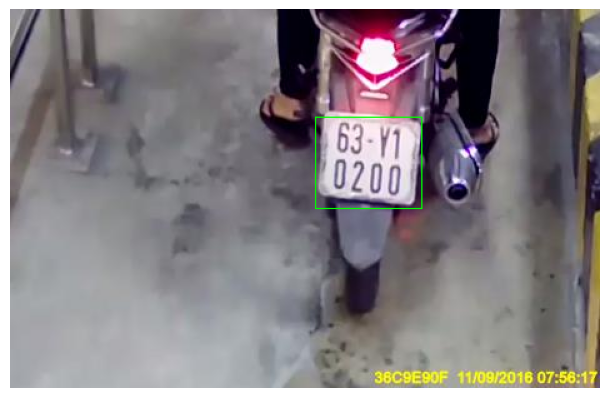

In [ ]:
display(img_copy)

In [ ]:
x1, y1, x2, y2 = (int(x_1), int(y_1), int(x_2), int(y_2))
crop = img[y1-12:y2+1, x1:x2]
resize = cv2.resize(crop, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)

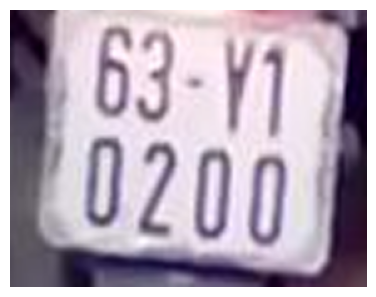

In [ ]:
display(resize)

## 02: Tìm góc xoay ảnh

* Làm mờ ảnh
* Tìm cạnh (canny)
* Tìm đường thẳng (HoughLinesP)



In [ ]:
import numpy as np
import math

def compute_skew(image):
    h, w, _ = image.shape

    img = cv2.medianBlur(image, 3)

    edges = cv2.Canny(img,  threshold1 = 30,  threshold2 = 100, apertureSize = 3, L2gradient = True)
    lines = cv2.HoughLinesP(edges, 1, math.pi/180, 30, minLineLength=w / 4.0, maxLineGap=h/4.0)
    angle = 0.0
    nlines = lines.size

    cnt = 0
    for x1, y1, x2, y2 in lines[0]:
        ang = np.arctan2(y2 - y1, x2 - x1)
        if math.fabs(ang) <= 30:
            angle += ang
            cnt += 1

    if cnt == 0:
        return 0.0
    return ( angle / cnt ) * 180 / math.pi

In [ ]:
def rotate_image(image, angle):
    center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def deskew(image):
    return rotate_image(image, compute_skew(image))

In [ ]:
rotated = deskew(resize)

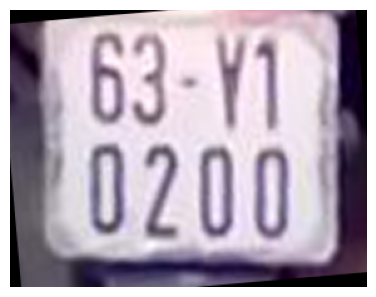

In [ ]:
display(rotated)

## 03: Tiền xử lý ảnh: Lấy mức xàm và làm mờ lọc nhiễu

In [ ]:
gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (9,9), 0)

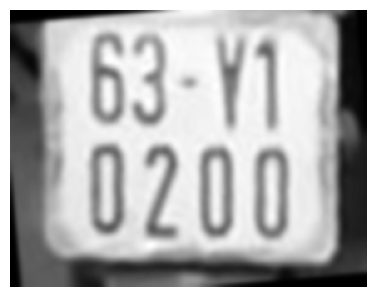

In [ ]:
display(blur)

### 04: Tiền xử lý ảnh: Giảm độ sáng để chống lóa

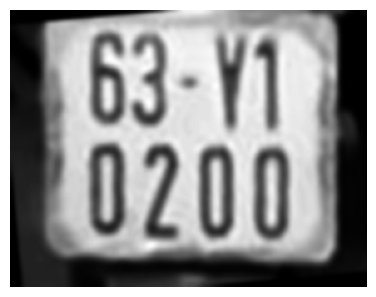

In [ ]:
def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([(i / 255.0) ** inv_gamma * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

gamma = adjust_gamma(blur, gamma=0.5)
display(gamma)

## 05: Tiền xử lý ảnh: Nhị phân hóa

In [ ]:
_, thresh = cv2.threshold(gamma, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)

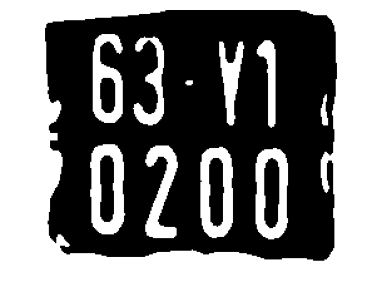

In [ ]:
display(thresh)

## 05: Tiền xử lý ảnh: Tăng độ dày chữ để tạo cạnh

In [ ]:
rect_kern = cv2.getStructuringElement(cv2.MORPH_RECT, (6, 4))
dilation = cv2.dilate(thresh, rect_kern, iterations=1)

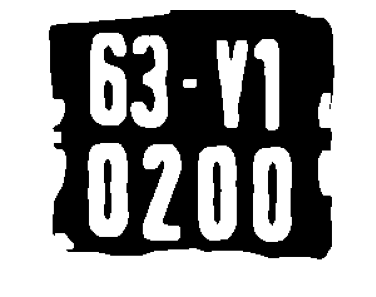

In [ ]:
display(dilation)

# ĐỌC BIỂN SỐ XE
- Sử dụng **pytesseract** để đọc ký tự


## 01: Tìm contours, sắp xếp từ trái sang phải và lấy countor chứa biển số xe

In [ ]:
cnts, _ = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
plate_cnt = sorted(cnts, key=cv2.contourArea, reverse=True)[1]
cnts = sorted(cnts, key=lambda ctr: cv2.boundingRect(ctr)[0])

## 02: Lọc contour không hợp lệ và phân loại biển
* Lọc viền ngoài của biển
* Lọc các contour có kích cỡ nhỏ
* Phân loại biển dài và biển ngắn





In [ ]:
top_half, bottom_half = [], []
rois = []

In [ ]:
height = cv2.boundingRect(plate_cnt)[-1]
width = cv2.boundingRect(plate_cnt)[-2]
img_copy = rotated.copy()
h, w, _ = img_copy.shape

if h / height > 1.5:
    height = h
    width = w

for cnt in cnts:
    x, y, w, h = cv2.boundingRect(cnt)
    if height / h > 4 or height / h < 1.5:
        continue

    roi = dilation[y-5:y + h +5, x-5:x+4 + w]
    roi = cv2.bitwise_not(roi)
    roi = cv2.medianBlur(roi, 5)
    cv2.rectangle(img_copy, (x - 5, y - 5), (x + w + 4, y + h + 5), (0, 255, 0), 1)
    if width / height >= 3.5:
        rois.append(roi)
    else:
        if y < height / 2 - 20:
            top_half.append(roi)
        else:
            bottom_half.append(roi)

In [ ]:
if (top_half and bottom_half):
    rois = top_half + bottom_half

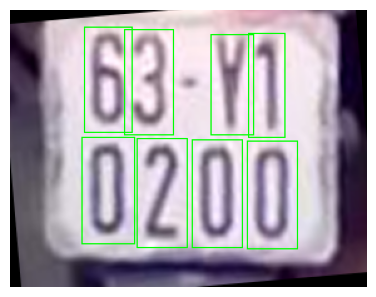

In [ ]:
display(img_copy)

## 03: Đọc ký tự

In [ ]:
max_height = max(roi.shape[0] for roi in rois)
_rois = [cv2.resize(roi, (roi.shape[1], max_height)) for roi in rois]

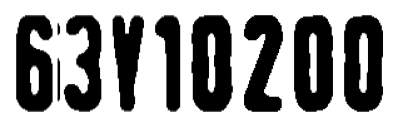

In [ ]:
display(cv2.hconcat(_rois))

In [ ]:
import pytesseract
plate_num = ''
for roi in _rois:
    char = pytesseract.image_to_string(roi, config='-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 8 --oem 3').strip()
    plate_num += char

In [ ]:
print(plate_num)

63Y10200
